# Classification of Wikipedia Text Versions
## Simple English vs Standard English
----
## Objective

The goal of this project is to train a supervised classifier capable of distinguishing between two versions of the same Wikipedia article:

- Simple English Wikipedia
- Standard English Wikipedia

This task represents a form of stylistic classification.

# Task 1 - Rami
Building the Binary (Normal/Simple) English Dataset

In [34]:
!pip install nltk requests pandas tqdm
import requests
import pandas as pd
import re
import time
import random

from tqdm import tqdm

import nltk
from nltk.tokenize import sent_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download("punkt")
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Configuration

In [4]:
# Number of articles we want in final dataset
TARGET_ARTICLES = 300

# Extra articles to compensate for filtering
BUFFER_ARTICLES = 150

# Maximum sentences per article version
MAX_SENT_PER_DOC = 40

# Sentence length limits
MIN_WORDS = 6
MAX_WORDS = 50

# Delay between Wikipedia API requests
REQUEST_DELAY = 0.2

# Fix randomness for reproducibility
random.seed(42)


# Create Wikipedia API Session
This improves connection stability, prevents request blocking (HTTP 403), and ensures reliable data collection.

In [25]:
session = requests.Session()

session.headers.update({
    "User-Agent": "M1-NLP-Nancy-Project/1.0 (Student Research Project)"
})


# Fetching Article Texts using wikipedia API

In [13]:
def fetch_article(title, language): # language is en or simple

    url = f"https://{language}.wikipedia.org/w/api.php"

    headers = {
        "User-Agent": "M1-NLP-Project/1.0 (Student project, Université de Lorraine)"
    }

    params = {
        "action": "query",
        "format": "json",
        "prop": "extracts", # to get the text as it is not metadata
        "explaintext": True, # No HTML Tags included
        "redirects": 1, # to enable shorcuts , ex : USA => United States of America
        "titles": title
    }

    try:

        response = requests.get(
            url,
            params=params,
            headers=headers,
            timeout=10
        ).json()

        pages = response["query"]["pages"]

        page = next(iter(pages.values())) # pages is a Dictionary but the key will be Random

        return page.get("extract", None)

    except:

        return None


# Check if the article exists in Standard Wikipedia

In [20]:
def exists_in_standard(title):

    url = "https://en.wikipedia.org/w/api.php"

    params = {
        "action": "query",
        "format": "json",
        "titles": title
    }

    try:

        response = session.get(
            url,
            params=params,
            timeout=10
        )

        data = response.json()

        pages = data["query"]["pages"]

        page = next(iter(pages.values()))

        return "missing" not in page

    except:

        return False


In [12]:
# testing the function
print(exists_in_standard("Moon"))

print(exists_in_standard("SomeRandomFakeArticleXYZ"))


True
False


# Get Random Paired Article Titles

In [26]:
def get_random_paired_titles(target=TARGET_ARTICLES, buffer=BUFFER_ARTICLES):

    needed = target + buffer

    titles = set()

    url = "https://simple.wikipedia.org/w/api.php"

    print("Fetching random titles from Simple Wikipedia...")

    while len(titles) < needed:

        params = {
            "action": "query",
            "format": "json",
            "list": "random",
            "rnnamespace": 0,
            "rnlimit": 50
        }

        try:

            response = session.get(
                url,
                params=params,
                timeout=10
            )

            data = response.json()

            for item in data["query"]["random"]:

                title = item["title"]

                if exists_in_standard(title):

                    titles.add(title)

        except:

            time.sleep(2)

            continue

        time.sleep(REQUEST_DELAY)

    titles = list(titles)[:target]

    print(f"Collected {len(titles)} paired article titles.")

    return titles


In [27]:
paired_titles = get_random_paired_titles()

print(paired_titles[:10])


Fetching random titles from Simple Wikipedia...
Collected 300 paired article titles.
['University of Silesia in Katowice', 'Bohemia', 'Ben, Iran', 'Barbara Darrow', 'Eurovision Song Contest 2014', 'Benguela', 'Abdirashid Shermarke', 'Le Lauzet-Ubaye', 'Reuben Hersh', 'Larry Wall']


## Clean Article Text


In [28]:
def clean_text(text):

    # remove reference numbers like [1], [2]
    text = re.sub(r"\[[0-9]+\]", "", text)

    # remove citation needed
    text = re.sub(r"\[citation needed\]", "", text, flags=re.IGNORECASE)

    # remove section headers like == History ==
    text = re.sub(r"==.*?==", "", text)

    # normalize whitespace
    text = re.sub(r"\s+", " ", text)

    return text.strip()



In [30]:
#test
raw = fetch_article("Moon", "simple")

clean = clean_text(raw)

print(clean[:500])


The Moon, also known as Luna, is Earth's only natural satellite (the only object which orbits the Earth and is not man-made). It is usually visible in the night sky, but is sometimes seen during the day. The Moon is about one-fourth of the width of Earth. Because it is so far away it looks small in the sky, about half a degree wide. The gravity on the Moon is one-sixth of the Earth's gravity. It means that an object will be one-sixth as heavy on the Moon compared to Earth. The Moon is a rocky an


# Filter Sentences
This function splits the article text into sentences and keeps only sentences within a defined length range.

Very short sentences often lack stylistic information, while extremely long sentences may introduce noise or bias.



In [31]:
def filter_sentences(sentences):

    valid = []

    for sentence in sentences:

        # count number of words in the sentence
        words = sentence.split()

        # keep only sentences within the acceptable length range
        if MIN_WORDS <= len(words) <= MAX_WORDS:

            valid.append(sentence)

    return valid


In [35]:
#test
text = fetch_article("Moon", "simple")

clean = clean_text(text)

sentences = sent_tokenize(clean)

filtered = filter_sentences(sentences)

print("Total:", len(sentences))

print("Filtered:", len(filtered))

print(filtered[:5])


Total: 95
Filtered: 86
["The Moon, also known as Luna, is Earth's only natural satellite (the only object which orbits the Earth and is not man-made).", 'It is usually visible in the night sky, but is sometimes seen during the day.', 'The Moon is about one-fourth of the width of Earth.', 'Because it is so far away it looks small in the sky, about half a degree wide.', "The gravity on the Moon is one-sixth of the Earth's gravity."]


# Building Dataset

In [40]:
def build_dataset():

    data = []

    # get random paired article titles
    titles = get_random_paired_titles()

    print("Building dataset...\n")

    for title in tqdm(titles, desc="Processing articles", unit="article"):

        # fetch simple and standard versions
        simple_text = fetch_article(title, "simple")

        standard_text = fetch_article(title, "en")

        # skip if any version is missing
        if not simple_text or not standard_text:
            continue

        # clean text
        simple_text = clean_text(simple_text)
        standard_text = clean_text(standard_text)

        # split into sentences
        simple_sentences = sent_tokenize(simple_text)
        standard_sentences = sent_tokenize(standard_text)

        # filter sentences
        simple_sentences = filter_sentences(simple_sentences)
        standard_sentences = filter_sentences(standard_sentences)

        # ensure equal number of sentences from both versions
        n = min(
            MAX_SENT_PER_DOC,
            len(simple_sentences),
            len(standard_sentences)
        )

        # skip if no valid sentences
        if n == 0:
            continue

        simple_sentences = random.sample(simple_sentences, n)

        standard_sentences = random.sample(standard_sentences, n)

        # add simple sentences
        for sentence in simple_sentences:

            data.append({
                "sentence": sentence,
                "label": "simple_wikipedia"
            })

        # add standard sentences
        for sentence in standard_sentences:

            data.append({
                "sentence": sentence,
                "label": "standard_wikipedia"
            })

        time.sleep(REQUEST_DELAY)

    dataset = pd.DataFrame(data)

    return dataset


# Construct Datset

In [41]:
dataset = build_dataset()

print("Dataset shape:")
print(dataset.shape)

print("\nLabel distribution:")
print(dataset["label"].value_counts())

print("\nDataset preview:")
dataset.head()


Fetching random titles from Simple Wikipedia...
Collected 300 paired article titles.
Building dataset...



Processing articles: 100%|██████████| 300/300 [01:32<00:00,  3.23article/s]

Dataset shape:
(1428, 2)

Label distribution:
label
simple_wikipedia      714
standard_wikipedia    714
Name: count, dtype: int64

Dataset preview:


,sentence,label
0,There are over a thousand Trans-Neptunian obje...,simple_wikipedia
1,Many are in the Kuiper belt.,simple_wikipedia
2,Trans-Neptunian object or TNO is a name astron...,simple_wikipedia
3,"Very red objects present a steep slope, reflec...",standard_wikipedia
4,NASA has been working towards a dedicated Inte...,standard_wikipedia


In [47]:
#save Dataset
dataset.to_csv(
    "Pilot_dataset_Sherbet.csv",
    index=False
)

print("Dataset saved successfully.")


Dataset saved successfully.


## Dataset Audit: Label Distribution


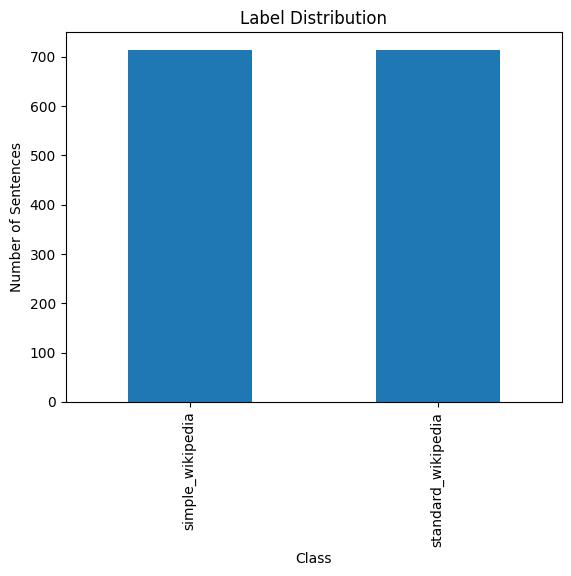

In [42]:
plt.figure()

dataset["label"].value_counts().plot(
    kind="bar"
)

plt.title("Label Distribution")

plt.xlabel("Class")

plt.ylabel("Number of Sentences")

plt.show()


# Dataset Audit: Sentence Length Distribution


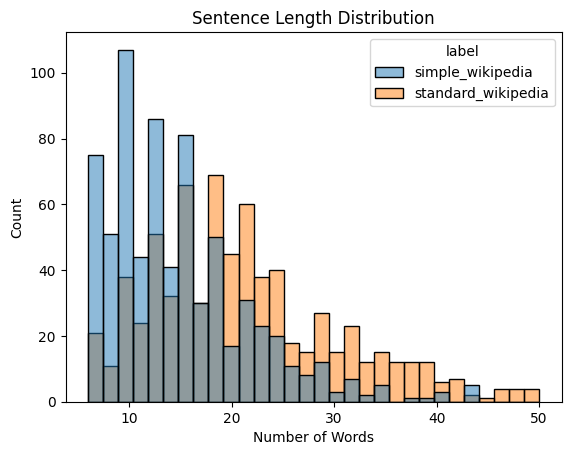

In [43]:
# compute sentence length

dataset["length"] = dataset["sentence"].apply(
    lambda x: len(x.split())
)


plt.figure()

sns.histplot(
    data=dataset,
    x="length",
    hue="label",
    bins=30
)

plt.title("Sentence Length Distribution")

plt.xlabel("Number of Words")

plt.ylabel("Count")

plt.show()


# Dataset Audit: Average Sentence Length


In [44]:
dataset.groupby("label")["length"].mean()


,length
label,
simple_wikipedia,14.795518
standard_wikipedia,21.172269


# Dataset Audit: Boxplot


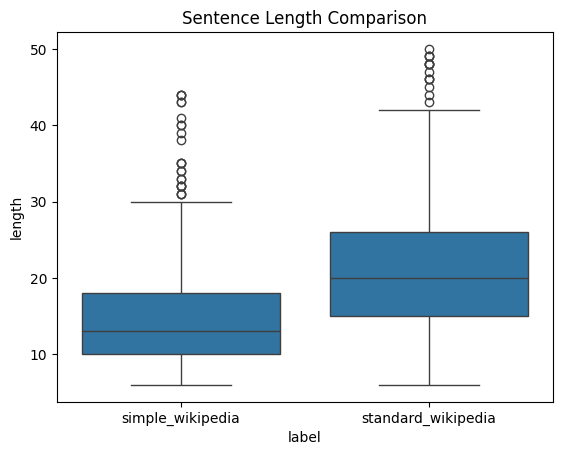

In [45]:
plt.figure()

sns.boxplot(
    data=dataset,
    x="label",
    y="length"
)

plt.title("Sentence Length Comparison")

plt.show()


# Dataset Audit: Class Balance Verification


Class balance (%):

label
simple_wikipedia      50.0
standard_wikipedia    50.0
Name: proportion, dtype: float64


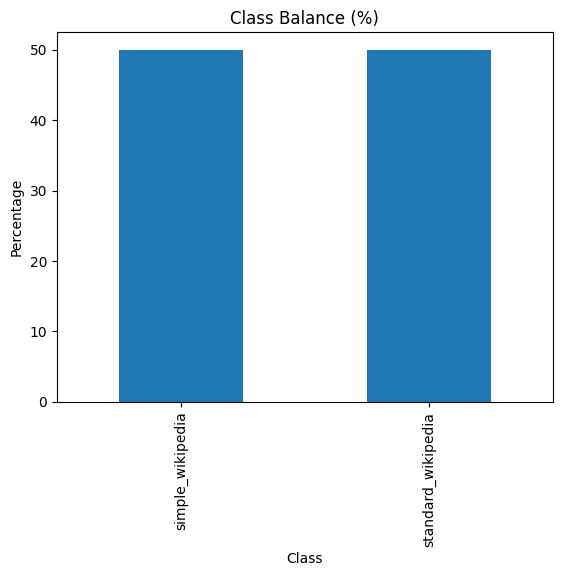

In [46]:
# calculate percentage distribution

balance = dataset["label"].value_counts(normalize=True) * 100

print("Class balance (%):\n")

print(balance)


plt.figure()

balance.plot(kind="bar")

plt.title("Class Balance (%)")

plt.ylabel("Percentage")

plt.xlabel("Class")

plt.show()
